In [3]:
# Import Libraries
import pickle
import random
import scipy.sparse as sp
import networkx as nx
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import cosine
import scipy.sparse as sp
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score
import math
import matplotlib.pyplot as plt
import itertools

In [12]:
# Define file paths
file_paths = {
    "x": "data/ind.citeseer.x",
    "y": "data/ind.citeseer.y",
    "tx": "data/ind.citeseer.tx",
    "ty": "data/ind.citeseer.ty",
    "allx": "data/ind.citeseer.allx",
    "ally": "data/ind.citeseer.ally",
    "graph": "data/ind.citeseer.graph",
    "test_index": "data/ind.citeseer.test.index"
}

In [13]:
# Load the dataset files
def load_data(file_paths):
    data = {}
    for key, path in file_paths.items():
        if key != "test_index":  # All files except test_index are pickled
            with open(path, 'rb') as file:
                data[key] = pickle.load(file, encoding='latin1')
        else:  # test_index is a text file
            with open(path, 'r') as file:
                data[key] = [int(line.strip()) for line in file]

    return data

def clean_graph(graph):
    cleaned_edges = set()
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            if node != neighbor:
                edge = tuple(sorted([node, neighbor]))
                cleaned_edges.add(edge)
    return cleaned_edges

In [14]:
data = load_data(file_paths)

cleaned_graph = clean_graph(data["graph"])

summary = {
    "Number of nodes": len(data["graph"]),
    "Original number of edges": sum(len(neighbors) for neighbors in data["graph"].values()) // 2,
    "Number of edges after removing self loops and duplicate edges": len(cleaned_graph),
    "Number of features": data["allx"].shape[1],
    "Number of classes": data["ally"].shape[1]
}

summary

<ipython-input-13-db211712be08>:7: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  data[key] = pickle.load(file, encoding='latin1')


{'Number of nodes': 3327,
 'Original number of edges': 4732,
 'Number of edges after removing self loops and duplicate edges': 4552,
 'Number of features': 3703,
 'Number of classes': 6}

In [16]:
# Node Homophily
def homophilyNode(graph, labelEncoding):
    nodeHomophily = 0

    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if not neighbors:
            continue
        homophilicConnections = 0
        for neighbor in neighbors:
            if np.argmax(labelEncoding[node]) == np.argmax(labelEncoding[neighbor]):
                homophilicConnections += 1
        homophilicConnections /=  len(neighbors)
        nodeHomophily += homophilicConnections

    nodeHomophily /= graph.number_of_nodes()

    return nodeHomophily
# Edge Homophily
def homophilyEdge(graph, labelEncoding):
    if not graph:
        return 0
    homophilicEdges = 0
    for edge in graph.edges():
        node_i, node_j = edge
        if np.argmax(labelEncoding[node_i]) == np.argmax(labelEncoding[node_j]):
            homophilicEdges += 1
    totalEdges = graph.number_of_edges()
    edgeHomophily = homophilicEdges / totalEdges if totalEdges else 0

    return edgeHomophily
# Class Homophily
def homophilyClass(G, labels):
    C = labels.shape[1]
    N = len(G.nodes())
    class_homophily = 0

    for k in range(C):
        numerator = 0
        denominator = 0
        class_node_count = 0

        for v in G.nodes():
            if labels[v, k] == 1:
                class_node_count += 1
                denominator += G.degree(v)

        for v in G.nodes():
            if labels[v, k] == 1:
                for u in G.neighbors(v):
                    if np.array_equal(labels[u, :], labels[v, :]):
                        numerator += 1

        hk = numerator / denominator if denominator != 0 else 0
        class_homophily += max(hk - (class_node_count / N), 0)

    class_homophily /= (C - 1) if C > 1 else 1
    return class_homophily
# Generalized Edge Homophily
def generalizedEdgeHomophily(G, features):
    total_cosine_similarity = 0

    for i, j in G.edges():
        feature_i = features[i].toarray()[0]
        feature_j = features[j].toarray()[0]

        cosine_similarity = 1 - cosine(feature_i, feature_j)
        total_cosine_similarity += cosine_similarity

    edge_count = G.number_of_edges()
    HGE = total_cosine_similarity / edge_count if edge_count != 0 else 0
    return HGE
# Adjusted Edge Homophily
def adjHomophily(graph, labelEncoding):

    adjHomophilyScore = 0
    totalComparisons = 0

    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        if not neighbors:
            continue

        for neighbor in neighbors:
            if np.argmax(labelEncoding[node]) == np.argmax(labelEncoding[neighbor]):
                adjHomophilyScore += 1
            totalComparisons += 1

    return adjHomophilyScore / totalComparisons if totalComparisons else 0

# def aggregateHomophily(G, features, labels):
#     A_hat = nx.adjacency_matrix(G) + sp.eye(G.number_of_nodes())
#     AZ = A_hat.dot(features)

#     S_AZ = AZ.dot(AZ.T)

#     count_v = 0
#     for v in range(G.number_of_nodes()):
#         same_class_similarity = []
#         diff_class_similarity = []

#         for u in range(G.number_of_nodes()):
#             if np.array_equal(labels[u], labels[v]):
#                 same_class_similarity.append(S_AZ[v, u])
#             else:
#                 diff_class_similarity.append(S_AZ[v, u])

#         mean_same = np.mean(same_class_similarity) if same_class_similarity else 0
#         mean_diff = np.mean(diff_class_similarity) if diff_class_similarity else 0

#         if mean_same >= mean_diff:
#             count_v += 1

#     H_agg = count_v / G.number_of_nodes()
#     return H_agg

In [17]:
import scipy.sparse as sp

def get_features(allx, tx, test_indices):
    max_index = max(test_indices) + 1
    total_size = max(allx.shape[0], max_index)

    full_features = sp.lil_matrix((total_size, allx.shape[1]), dtype=np.float32)

    full_features[:allx.shape[0], :] = allx
    for i, idx in enumerate(test_indices):
        full_features[idx] = tx[i]

    return full_features.tocsr()

features = get_features(data['allx'], data['tx'], data['test_index'])
print(features.shape, data['allx'].shape, data['tx'].shape)

(3327, 3703) (2312, 3703) (1000, 3703)


In [18]:
G = nx.Graph()

labels_y = data['y']
labels_ty = data['ty']
labels_ally = data['ally']
test_indices = data['test_index']

expanded_labels = np.zeros((3327, 6))
expanded_labels[:2312, :] = labels_ally


full_labels = expanded_labels.copy()
for i, index in enumerate(test_indices):
    full_labels[index] = labels_ty[i]
for node in range(3326 + 1):
    G.add_node(node)

# Add edges, avoiding self loops
for node, neighbors in data["graph"].items():
    for neighbor in neighbors:
        if node != neighbor:
            G.add_edge(node, neighbor)

print("Number of nodes in G after adding all nodes explicitly:", G.number_of_nodes())

Number of nodes in G after adding all nodes explicitly: 3327


In [19]:

nodeHomophily = homophilyNode(G, full_labels)
edgeHomophily = homophilyEdge(G,full_labels)
classHomophily = homophilyClass(G,full_labels)
GEhomophily = generalizedEdgeHomophily(G,features)
Adjhomophily = adjHomophily(G,full_labels)

print("Node homophily is", nodeHomophily)
print("Edge homophily is", edgeHomophily)
print("Class homophily is", classHomophily)
print("GE homophily is", GEhomophily);
print("Adj homophily is", Adjhomophily);
print("Number of nodes in G:", G.number_of_nodes())
print("Shape of features:", features.shape)

/usr/local/lib/python3.10/dist-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in float_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Node homophily is 0.706249161762248
Edge homophily is 0.7355008787346221
Class homophily is 0.6283437645725868
GE homophily is 0.19414880454437136
Adj homophily is 0.7355008787346221
Number of nodes in G: 3327
Shape of features: (3327, 3703)


# Number of nodes in G: 3327
Shape of features: (3327, 3703)

Node homophily is 0.706249161762248

Edge homophily is 0.7355008787346221

Class homophily is 0.6283437645725868

GE homophily is 0.19414880454437136

Adj homophily is 0.7355008787346221

In [20]:
# Label spreading
def onehot_decode(matrix):
    decoded_matrix = np.argmax(matrix, axis=1)
    return decoded_matrix

label_spreading_model = LabelSpreading(kernel='knn',n_neighbors=146, max_iter=1000)
label_spreading_model.fit(data['allx'].toarray(), onehot_decode(data['ally']))
y_pred = label_spreading_model.predict(data['tx'])
accuracy = accuracy_score(onehot_decode(data['ty']), y_pred)

print(f'Accuracy: {accuracy:.3f}')



Accuracy: 0.632


<ipython-input-21-938481b4f034>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('viridis', np.max(class_labels) + 1)


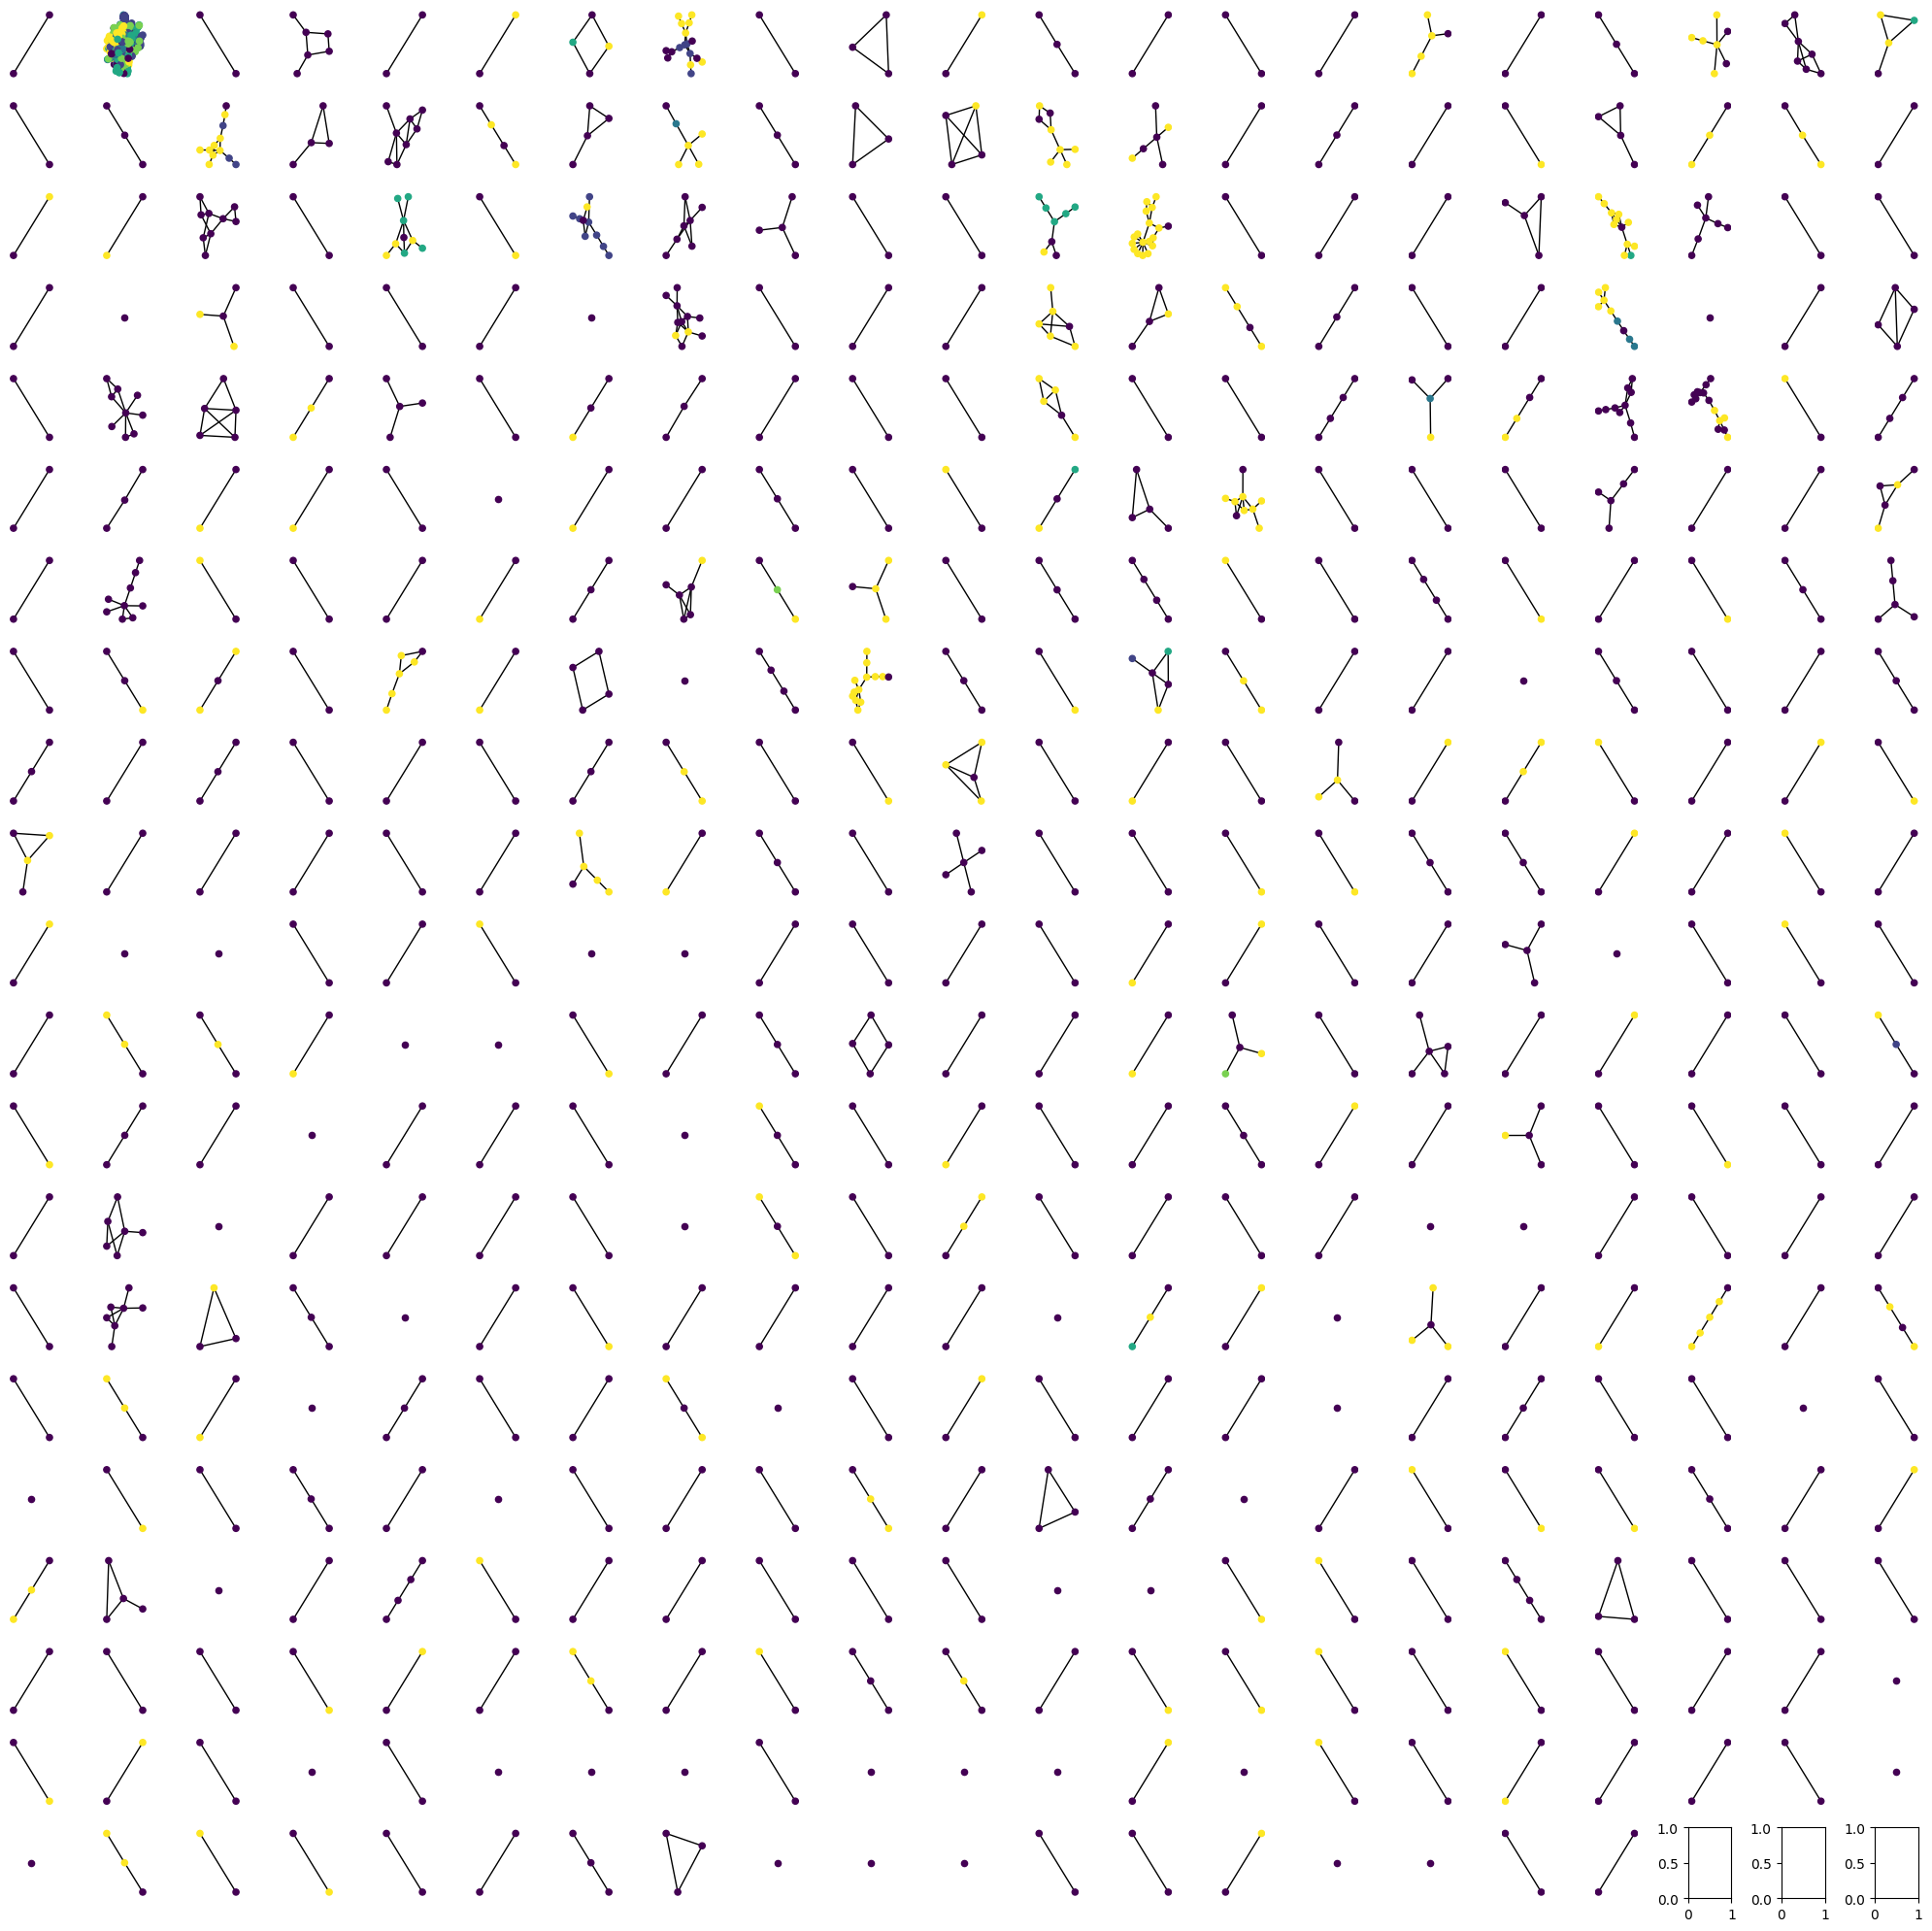

In [21]:
subgraphs = [G.subgraph(c).copy() for c in nx.connected_components(G)]

num_subgraphs = len(subgraphs)
grid_size = math.ceil(math.sqrt(num_subgraphs))
class_labels = np.argmax(full_labels, axis=1)  # Assuming full_labels is your label matrix
# Define a color map
color_map = plt.cm.get_cmap('viridis', np.max(class_labels) + 1)

fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))
axes = axes.flatten()

for i, sg in enumerate(subgraphs):
    pos = nx.spring_layout(sg)  # Layout for the subgraph

    # Extract the class labels for nodes in this subgraph
    subgraph_labels = [class_labels[node] for node in sg.nodes()]

    # Draw the subgraph
    nx.draw(sg, pos, ax=axes[i], node_size=20, node_color=subgraph_labels, cmap=color_map, with_labels=False)

    # Hide axes for empty plots
    if i >= num_subgraphs:
        axes[i].axis('off')

plt.tight_layout()
plt.show()



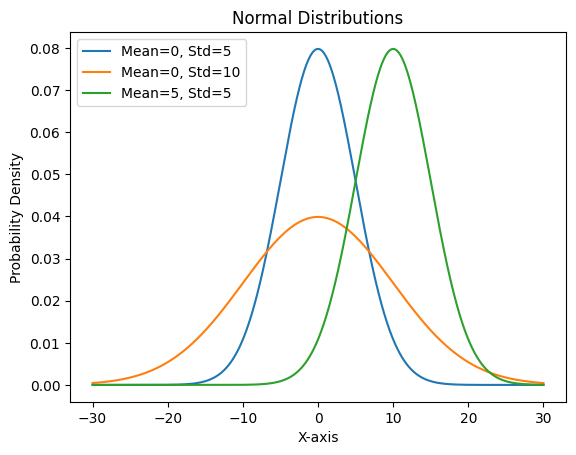

In [24]:
# PLotting normal distribution with varired mean and variances
# Parameters for the first normal distribution
mean1 = 0
std1 = 5

# Parameters for the second normal distribution
mean2 = 0
std2 = 10

# Parameters for the third normal distribution
mean3 = 10
std3 = 5

# Generate data points for the x-axis
x = np.linspace(-30, 30, 1000)

# Generate PDF for two normal distributions
pdf1 = (1 / (std1 * np.sqrt(2 * np.pi))) * np.exp(-(x - mean1)**2 / (2 * std1**2))
pdf2 = (1 / (std2 * np.sqrt(2 * np.pi))) * np.exp(-(x - mean2)**2 / (2 * std2**2))
pdf3 = (1 / (std3 * np.sqrt(2 * np.pi))) * np.exp(-(x - mean3)**2 / (2 * std3**2))

# Plot the two distributions
plt.plot(x, pdf1, label='Mean=0, Std=5')
plt.plot(x, pdf2, label='Mean=0, Std=10')
plt.plot(x, pdf3, label='Mean=5, Std=5')
plt.title('Normal Distributions')
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [30]:
# Function to modify homophily values of citeseer dataset by adding or removing edges
def modify_homophily(G, labels, edge_modification_percent, increase_homophily):
    """
    Modify edges in the graph to either increase or decrease homophily.

    Args:
    - G (networkx.Graph): The graph.
    - labels (numpy array): Node labels.
    - edge_modification_percent (float): Percentage of edges to modify.
    - increase_homophily (bool): If True, increase homophily, else decrease.

    Returns:
    - networkx.Graph: The modified graph.
    """
    modified_G = G.copy()
    num_edges_to_modify = int(edge_modification_percent * modified_G.number_of_edges())

    # Function to check if two nodes are of the same class
    same_class = lambda u, v: np.argmax(labels[u]) == np.argmax(labels[v])

    # Get all possible edges to add
    possible_add_edges = [(u, v) for u, v in nx.non_edges(modified_G) if same_class(u, v) == increase_homophily]

    # Randomly shuffle the possible edges to add
    random.shuffle(possible_add_edges)

    edges_modified = 0
    for edge in modified_G.edges():
        u, v = edge
        if same_class(u, v) != increase_homophily and edges_modified < num_edges_to_modify:
            # Remove the edge and add a new one
            modified_G.remove_edge(u, v)
            new_edge = possible_add_edges.pop()
            modified_G.add_edge(*new_edge)
            edges_modified += 1

        if edges_modified >= num_edges_to_modify:
            break

    return modified_G

def reduce_homophily(G, labels, edge_modification_percent):
    return modify_homophily(G, labels, edge_modification_percent, increase_homophily=False)

def increase_homophily(G, labels, edge_modification_percent):
    return modify_homophily(G, labels, edge_modification_percent, increase_homophily=True)

modified_G_reduce = reduce_homophily(G, full_labels, 0.1)  # Modify 10% of edges to reduce homophily
modified_G_increase = increase_homophily(G, full_labels, 0.1)  # Modify 10% of edges to increase homophily

In [28]:
edgeHomophily = homophilyEdge(modified_G_increase,full_labels)
print("Increased homophily")
print("Edge homophily is", edgeHomophily)
print("Number of nodes in G:", modified_G_increase.number_of_nodes())
print("Shape of features:", features.shape)

Increased homophily
Edge homophily is 0.835456942003515
Number of nodes in G: 3327
Shape of features: (3327, 3703)


In [ ]:
edgeHomophily = homophilyEdge(modified_G_reduce,full_labels)
print("Decreased homophily")
print("Edge homophily is", edgeHomophily)
print("Number of nodes in G:", modified_G_reduce.number_of_nodes())
print("Shape of features:", features.shape)

Edge homophily is 0.6355448154657294
Number of nodes in G: 3327
Shape of features: (3327, 3703)


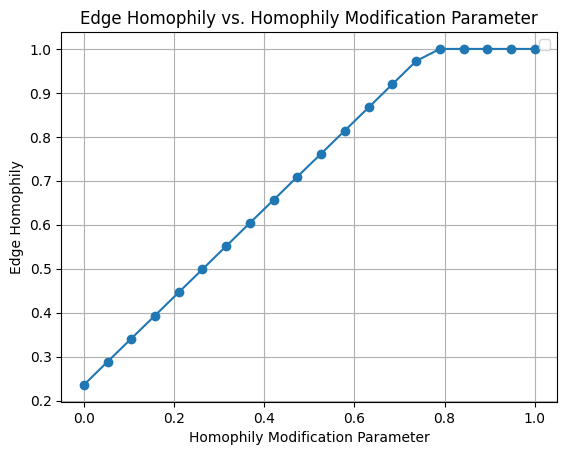

In [87]:
# Modify % of edges to be modified and plotting it against edge homophily
edge_mod_per = np.linspace(0,1, 20)
edge_homophily_levels = []

for param in edge_mod_per:
  if param > 0.5:
    modified_G = increase_homophily(G, full_labels, param - 0.5)
  else:
    modified_G = reduce_homophily(G, full_labels, 0.5 - param)

  edge_homophily = homophilyEdge(modified_G, full_labels)
  edge_homophily_levels.append(edge_homophily)


# Plotting
plt.plot(edge_mod_per, edge_homophily_levels, marker='o')
plt.xlabel('Homophily Modification Parameter')
plt.ylabel('Edge Homophily')
plt.title('Edge Homophily vs. Homophily Modification Parameter')
plt.grid(True)
plt.legend()
plt.show()

In [31]:
# CSBM-H
def csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=2):
  """
    :param pass: 0 => low pass filtered, 1=> high pass filtered, 2=> full pass filtered.
  """
  # Step 1: Defining parameters
  num_nodes_c0 = 50  # Number of nodes in C0
  num_nodes_c1 = 50  # Number of nodes in C1
  Fh = 2  # Feature dimensions

  # Step 2: Construct the Graph
  G1 = nx.Graph()

  # Adding nodes for each class
  G1.add_nodes_from(range(num_nodes_c0 + num_nodes_c1))
  # Function to add edges based on homophily
  def add_edges(G, num_nodes, start_idx, degree, h, inter_class_start):
      intra_edges = int(h * degree)
      inter_edges = degree - intra_edges

      for node in range(start_idx, start_idx + num_nodes):
          # Intra-class edges
          intra_class_nodes = [i for i in range(start_idx, start_idx + num_nodes) if i != node]
          chosen_intra = np.random.choice(intra_class_nodes, intra_edges, replace=True)
          # Inter-class edges
          inter_class_nodes = [i for i in range(inter_class_start, inter_class_start + num_nodes_c1)]
          chosen_inter = np.random.choice(inter_class_nodes, inter_edges, replace=True)
          # Adding edges
          for target in itertools.chain(chosen_intra, chosen_inter):
              G.add_edge(node, target)

  # Add edges for C0 and C1
  add_edges(G1, num_nodes_c0, 0, d0, h, num_nodes_c0)
  add_edges(G1, num_nodes_c1, num_nodes_c0, d1, h, 0)

  # Step 3: Calculate Filtered Feature Parameters
  tilde_mu0 = h * (mu0 - mu1) + mu1
  tilde_mu1 = h * (mu1 - mu0) + mu0

  tilde_mu0_hp = (1-h) * (mu0 - mu1)
  tilde_mu1_hp = (1-h) * (mu1 - mu0)

  tilde_sigma_square_0 = (h * (sigma_square_0 - sigma_square_1) + sigma_square_1) / d0
  tilde_sigma_square_1 = (h * (sigma_square_1 - sigma_square_0) + sigma_square_0) / d1

  tilde_sigma_square_0_hp = sigma_square_0 + ((h * (sigma_square_0 - sigma_square_1) + sigma_square_1) / d0)
  tilde_sigma_square_1_hp = sigma_square_1 + ((h * (sigma_square_1 - sigma_square_0) + sigma_square_0) / d1)

  # Step 4: Generate Filtered Features
  # Full pass filtered features
  if(pass_type == 2):
    fp_features_c0 = np.random.normal(mu0, sigma_square_0, (num_nodes_c0, Fh))
    fp_features_c1 = np.random.normal(mu1, sigma_square_1, (num_nodes_c1, Fh))
    return G1, mu0, mu1, sigma_square_0, sigma_square_1, fp_features_c0, fp_features_c1
  # Low pass filtered features
  if (pass_type == 0):
    lp_features_c0 = np.random.normal(tilde_mu0, tilde_sigma_square_0, (num_nodes_c0, Fh))
    lp_features_c1 = np.random.normal(tilde_mu1, tilde_sigma_square_1, (num_nodes_c1, Fh))
    return G1, tilde_mu0, tilde_mu1, tilde_sigma_square_0, tilde_sigma_square_1, lp_features_c0, lp_features_c1
  # High pass filtered features
  if (pass_type == 1):
    hp_features_c0 = np.random.normal(tilde_mu0_hp, tilde_sigma_square_0_hp, (num_nodes_c0, Fh))
    hp_features_c1 = np.random.normal(tilde_mu1_hp, tilde_sigma_square_1_hp, (num_nodes_c1, Fh))
    return G1, tilde_mu0_hp, tilde_mu1_hp, tilde_sigma_square_0_hp, tilde_sigma_square_1_hp, hp_features_c0, hp_features_c1
#########################################
# Demo of above function
# mu0 = np.array([-1, 0])
# mu1 = np.array([0, 1])
# sigma_square_0, sigma_square_1 = 1.0, 2.0  # Variances for each class
# d0, d1 = 5, 5  # Degrees for each class
# h = 0.6  # Homophily parameter
# G1, features_c0, features_c1 = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=2)


In [32]:
# Bayes classifier
def bayes_classifier(x, sigma_square_0, sigma_square_1, mu0, mu1, fh):
  a = 0.5 * (1/sigma_square_1 - 1/sigma_square_0)
  b = (mu0 / sigma_square_0) - (mu1 / sigma_square_1)
  c =  (np.dot(mu1.T, mu1) / (2 * sigma_square_1)) - (np.dot(mu0.T, mu0) / (2 * sigma_square_0))

  def Q(x, a, b, c):
      return a * np.dot(x.T, x) + np.dot(b.T, x) + c
  def eta(x, a, b, c):
      return 1 / (1 + np.exp(Q(x, a, b, c)))
  return 1 if eta(x, a, b, c) >= 0.5 else 0

In [35]:
# Generalized chi square distribution
def cdf_chi2gen(w, Fh, lambda_, xi, num_samples=10000):
    """
    Approximate the CDF of a generalized chi-squared distribution using Monte Carlo simulation.

    :param w: Weight in the generalized chi-squared distribution.
    :param Fh: Degrees of freedom.
    :param lambda_: Non-centrality parameter.
    :param xi: Value at which to evaluate the CDF.
    :param num_samples: Number of samples to use in the Monte Carlo simulation.
    :return: Approximated CDF value.
    """
    samples = np.zeros(num_samples)
    for i in range(Fh):
        samples += w * np.random.noncentral_chisquare(df=1, nonc=lambda_, size=num_samples)
    return np.mean(samples <= xi)

# Function to calculate PBE
def calculate_pbe(mu0, mu1, sigma0, sigma1, fh):
    a = 0.5 * (1/sigma1**2 - 1/sigma0**2)
    b = (mu0 / sigma0**2) - (mu1 / sigma1**2)
    c =  (np.dot(mu1.T, mu1) / (2 * (sigma1**2))) - (np.dot(mu0.T, mu0) / (2 * (sigma0**2))) + math.log((sigma1**fh)/(sigma0**fh))

    w0 = a * (sigma0**2)
    w1 = a * (sigma1**2)
    λ0 = np.dot(((mu0 / sigma0) + (b / (2 * a * sigma0))).T, ((mu0 / sigma0) +(b / (2 * a * sigma0))))
    λ1 = np.dot(((mu1 / sigma1) + (b / (2 * a * sigma1))).T, ((mu1 / sigma1) +(b / (2 * a * sigma1))))
    ξ = c - (np.dot(b.T, b) / (4 * a))

    p0 = cdf_chi2gen(w0, fh, λ0, -ξ)
    p1 = cdf_chi2gen(w1, fh, λ1, -ξ)
    return (p0 + (1 - p1)) / 2

# Function to calculate  Generalized Jeffreys Divergence
def calculate_dngj(mu0, mu1, sigma0, sigma1, Fh):
    dx_squared = np.dot((mu0 - mu1).T, (mu0 - mu1))
    rho = sigma0 / sigma1
    return -dx_squared * (1 / (4 * sigma1**2) + 1 / (4 * sigma0**2)) - ((Fh / 4) * (rho**2 + 1 / rho**2 - 2))

# Function to calculate Expected Negative Normalized Distance
def calculate_nnd(mu0, mu1, sigma0, sigma1):
    dx_squared = np.dot((mu0 - mu1).T, (mu0 - mu1))
    return -dx_squared * (1 / (4 * sigma1**2) + 1 / (4 * sigma0**2))

# Function to calculate Negative Variance Ration
def calculate_nvr(sigma0, sigma1, Fh):
    rho = sigma0 / sigma1
    return - (Fh / 4) * (rho**2 + 1 / rho**2 - 2)

In [63]:
# Function to calcuate PBE for all the filtered features
def calculate_pbe_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh):
  _, nm0_fp, nm1_fp, ns0s_fp, ns1s_fp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=2)
  pbe_fp = calculate_pbe(nm0_fp, nm1_fp, np.sqrt(ns0s_fp), np.sqrt(ns1s_fp), fh)

  _, nm0_lp, nm1_lp, ns0s_lp, ns1s_lp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=0)
  pbe_lp = calculate_pbe(nm0_lp, nm1_lp, np.sqrt(ns0s_lp), np.sqrt(ns1s_lp), fh)

  _, nm0_hp, nm1_hp, ns0s_hp, ns1s_hp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=1)
  pbe_hp = calculate_pbe(nm0_hp, nm1_hp, np.sqrt(ns0s_hp), np.sqrt(ns1s_hp), fh)

  return pbe_fp, pbe_lp, pbe_hp

# Function to calcuate Dngj for all the filtered features
def calculate_dngj_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh):
  _, nm0_fp, nm1_fp, ns0s_fp, ns1s_fp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=2)
  dngj_fp = calculate_dngj(nm0_fp, nm1_fp, np.sqrt(ns0s_fp), np.sqrt(ns1s_fp), fh)

  _, nm0_lp, nm1_lp, ns0s_lp, ns1s_lp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=0)
  dngj_lp = calculate_dngj(nm0_lp, nm1_lp, np.sqrt(ns0s_lp), np.sqrt(ns1s_lp), fh)

  _, nm0_hp, nm1_hp, ns0s_hp, ns1s_hp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=1)
  dngj_hp = calculate_dngj(nm0_hp, nm1_hp, np.sqrt(ns0s_hp), np.sqrt(ns1s_hp), fh)

  return dngj_fp, dngj_lp, dngj_hp

# Function to calcuate NND for all the filtered features
def calculate_nnd_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh):
  _, nm0_fp, nm1_fp, ns0s_fp, ns1s_fp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=2)
  nnd_fp = calculate_nnd(nm0_fp, nm1_fp, np.sqrt(ns0s_fp), np.sqrt(ns1s_fp))

  _, nm0_lp, nm1_lp, ns0s_lp, ns1s_lp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=0)
  nnd_lp = calculate_nnd(nm0_lp, nm1_lp, np.sqrt(ns0s_lp), np.sqrt(ns1s_lp))

  _, nm0_hp, nm1_hp, ns0s_hp, ns1s_hp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=1)
  nnd_hp = calculate_nnd(nm0_hp, nm1_hp, np.sqrt(ns0s_hp), np.sqrt(ns1s_hp))

  return nnd_fp, nnd_lp, nnd_hp

# Function to calcuate NVR for all the filtered features
def calculate_nvr_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh):
  _, nm0_fp, nm1_fp, ns0s_fp, ns1s_fp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=2)
  nvr_fp = calculate_nvr(np.sqrt(ns0s_fp), np.sqrt(ns1s_fp), fh)

  _, nm0_lp, nm1_lp, ns0s_lp, ns1s_lp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=0)
  nvr_lp = calculate_nvr(np.sqrt(ns0s_lp), np.sqrt(ns1s_lp), fh)

  _, nm0_hp, nm1_hp, ns0s_hp, ns1s_hp, _, _ = csbm_H(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, pass_type=1)
  nvr_hp = calculate_nvr(np.sqrt(ns0s_hp), np.sqrt(ns1s_hp), fh)

  return nvr_fp, nvr_lp, nvr_hp

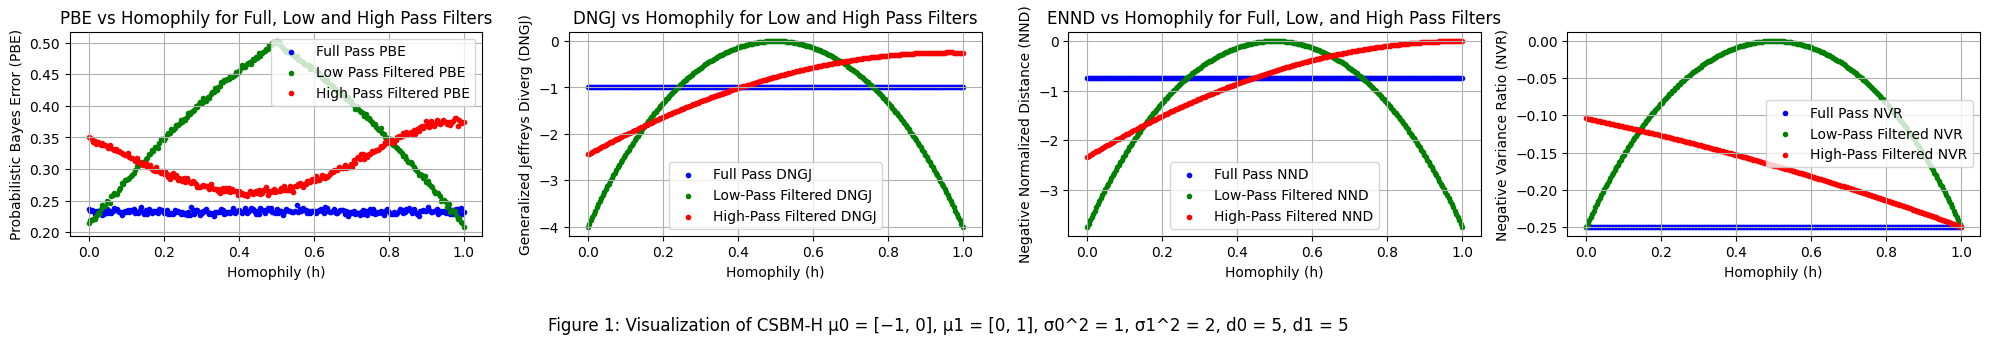

In [78]:
'''
Plotting PBE, Dngj, NND and NVR
mu0 = [-1, 0]
mu1 = [0, 1]

sigma_0^2 = 1.0
sigma_1^2 = 2.0

d0 = 5
d1 = 5

fh = 2
'''
mu0 = np.array([-1, 0])
mu1 = np.array([0, 1])
sigma_square_0, sigma_square_1 = 1.0, 2.0  # Variances for each class
fh = 2
d0, d1 = 5, 5  # Degrees for each class

homophily_values = np.linspace(0,1, 250)

# Calculating PBE
pbe_fp_all = []
pbe_lp_all = []
pbe_hp_all = []

# Calculating Dngj
dngj_fp_all = []
dngj_lp_all = []
dngj_hp_all = []

# Calculating NND
nnd_fp_all = []
nnd_lp_all = []
nnd_hp_all = []

# Calculating NVR
nvr_fp_all = []
nvr_lp_all = []
nvr_hp_all = []


for h in homophily_values:
  pbe_fp, pbe_lp, pbe_hp = calculate_pbe_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  dngj_fp, dngj_lp, dngj_hp = calculate_dngj_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nnd_fp, nnd_lp, nnd_hp = calculate_nnd_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nvr_fp, nvr_lp, nvr_hp = calculate_nvr_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)

  pbe_fp_all.append(pbe_fp)
  pbe_lp_all.append(pbe_lp)
  pbe_hp_all.append(pbe_hp)

  dngj_fp_all.append(dngj_fp)
  dngj_lp_all.append(dngj_lp)
  dngj_hp_all.append(dngj_hp)

  nnd_fp_all.append(nnd_fp)
  nnd_lp_all.append(nnd_lp)
  nnd_hp_all.append(nnd_hp)

  nvr_fp_all.append(nvr_fp)
  nvr_lp_all.append(nvr_lp)
  nvr_hp_all.append(nvr_hp)


plt.figure(figsize=(20, 3))
# Plotting PBE
plt.subplot(1, 4, 1)
plt.scatter(homophily_values, pbe_fp_all, marker='.', c='b', label='Full Pass PBE')
plt.scatter(homophily_values, pbe_lp_all, marker='.', c='g', label='Low Pass Filtered PBE')
plt.scatter(homophily_values, pbe_hp_all, marker='.', c='r', label='High Pass Filtered PBE')
plt.grid(True)
plt.xlabel('Homophily (h)')
plt.ylabel('Probabilistic Bayes Error (PBE)')
plt.title('PBE vs Homophily for Full, Low and High Pass Filters')
plt.legend()

# Plotting Dngj
plt.subplot(1, 4, 2)
plt.scatter(homophily_values, dngj_fp_all, marker='.', c='b', label='Full Pass DNGJ')
plt.scatter(homophily_values, dngj_lp_all, marker='.', c='g', label='Low-Pass Filtered DNGJ')
plt.scatter(homophily_values, dngj_hp_all, marker='.', c='r', label='High-Pass Filtered DNGJ')
plt.xlabel('Homophily (h)')
plt.ylabel('Generalized Jeffreys Diverg (DNGJ)')
plt.title('DNGJ vs Homophily for Low and High Pass Filters')
plt.legend()
plt.grid(True)

# Plotting NND
plt.subplot(1, 4, 3)
plt.scatter(homophily_values, nnd_fp_all, marker='.', c='b', label='Full Pass NND')
plt.scatter(homophily_values, nnd_lp_all, marker='.', c='g', label='Low-Pass Filtered NND')
plt.scatter(homophily_values, nnd_hp_all, marker='.', c='r', label='High-Pass Filtered NND')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Normalized Distance (NND)')
plt.title('ENND vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

# Plotting NVR
plt.subplot(1, 4, 4)
plt.scatter(homophily_values, nvr_fp_all, marker='.', c='b', label='Full Pass NVR')
plt.scatter(homophily_values, nvr_lp_all, marker='.', c='g', label='Low-Pass Filtered NVR')
plt.scatter(homophily_values, nvr_hp_all, marker='.', c='r', label='High-Pass Filtered NVR')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Variance Ratio (NVR)')
plt.title('NVR vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.title("Figure 1: Visualization of CSBM-H µ0 = [−1, 0], µ1 = [0, 1], σ0^2 = 1, σ1^2 = 2, d0 = 5, d1 = 5", y = -0.5, x = -1.5)
plt.show()

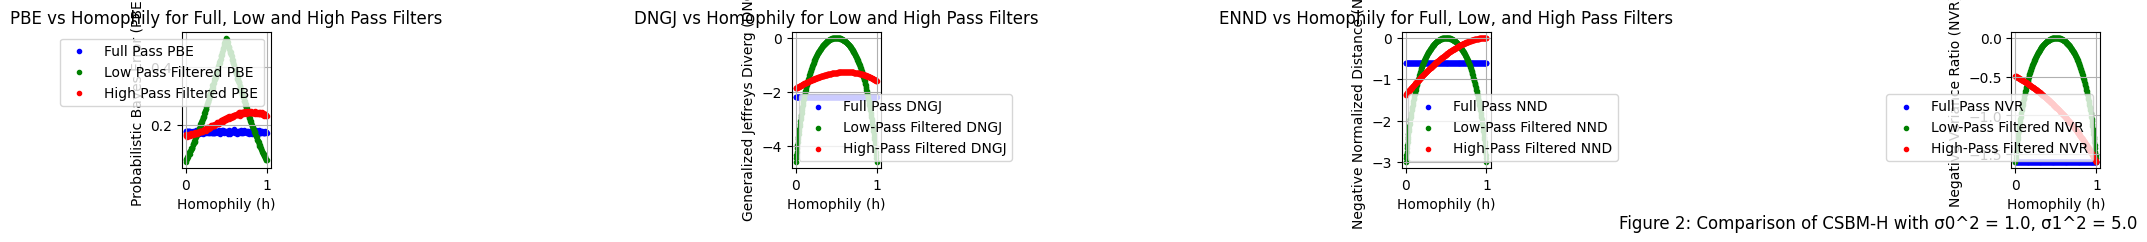

In [79]:
# sigma_1^2 changed to 5.0
'''
Plotting PBE, Dngj, NND and NVR
mu0 = [-1, 0]
mu1 = [0, 1]

sigma_0^2 = 1.0
sigma_1^2 = 5.0

d0 = 5
d1 = 5

fh = 2
'''
mu0 = np.array([-1, 0])
mu1 = np.array([0, 1])
sigma_square_0, sigma_square_1 = 1.0, 5.0  # Variances for each class
fh = 2
d0, d1 = 5, 5  # Degrees for each class

homophily_values = np.linspace(0,1, 250)

# Calculating PBE
pbe_fp_all = []
pbe_lp_all = []
pbe_hp_all = []

# Calculating Dngj
dngj_fp_all = []
dngj_lp_all = []
dngj_hp_all = []

# Calculating NND
nnd_fp_all = []
nnd_lp_all = []
nnd_hp_all = []

# Calculating NVR
nvr_fp_all = []
nvr_lp_all = []
nvr_hp_all = []


for h in homophily_values:
  pbe_fp, pbe_lp, pbe_hp = calculate_pbe_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  dngj_fp, dngj_lp, dngj_hp = calculate_dngj_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nnd_fp, nnd_lp, nnd_hp = calculate_nnd_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nvr_fp, nvr_lp, nvr_hp = calculate_nvr_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)

  pbe_fp_all.append(pbe_fp)
  pbe_lp_all.append(pbe_lp)
  pbe_hp_all.append(pbe_hp)

  dngj_fp_all.append(dngj_fp)
  dngj_lp_all.append(dngj_lp)
  dngj_hp_all.append(dngj_hp)

  nnd_fp_all.append(nnd_fp)
  nnd_lp_all.append(nnd_lp)
  nnd_hp_all.append(nnd_hp)

  nvr_fp_all.append(nvr_fp)
  nvr_lp_all.append(nvr_lp)
  nvr_hp_all.append(nvr_hp)


plt.figure(figsize=(20, 3))
# Plotting PBE
plt.subplot(1, 4, 1)
plt.scatter(homophily_values, pbe_fp_all, marker='.', c='b', label='Full Pass PBE')
plt.scatter(homophily_values, pbe_lp_all, marker='.', c='g', label='Low Pass Filtered PBE')
plt.scatter(homophily_values, pbe_hp_all, marker='.', c='r', label='High Pass Filtered PBE')
plt.grid(True)
plt.xlabel('Homophily (h)')
plt.ylabel('Probabilistic Bayes Error (PBE)')
plt.title('PBE vs Homophily for Full, Low and High Pass Filters')
plt.legend()

# Plotting Dngj
plt.subplot(1, 4, 2)
plt.scatter(homophily_values, dngj_fp_all, marker='.', c='b', label='Full Pass DNGJ')
plt.scatter(homophily_values, dngj_lp_all, marker='.', c='g', label='Low-Pass Filtered DNGJ')
plt.scatter(homophily_values, dngj_hp_all, marker='.', c='r', label='High-Pass Filtered DNGJ')
plt.xlabel('Homophily (h)')
plt.ylabel('Generalized Jeffreys Diverg (DNGJ)')
plt.title('DNGJ vs Homophily for Low and High Pass Filters')
plt.legend()
plt.grid(True)

# Plotting NND
plt.subplot(1, 4, 3)
plt.scatter(homophily_values, nnd_fp_all, marker='.', c='b', label='Full Pass NND')
plt.scatter(homophily_values, nnd_lp_all, marker='.', c='g', label='Low-Pass Filtered NND')
plt.scatter(homophily_values, nnd_hp_all, marker='.', c='r', label='High-Pass Filtered NND')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Normalized Distance (NND)')
plt.title('ENND vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

# Plotting NVR
plt.subplot(1, 4, 4)
plt.scatter(homophily_values, nvr_fp_all, marker='.', c='b', label='Full Pass NVR')
plt.scatter(homophily_values, nvr_lp_all, marker='.', c='g', label='Low-Pass Filtered NVR')
plt.scatter(homophily_values, nvr_hp_all, marker='.', c='r', label='High-Pass Filtered NVR')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Variance Ratio (NVR)')
plt.title('NVR vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

plt.title("Figure 2: Comparison of CSBM-H with σ0^2 = 1.0, σ1^2 = 5.0", y = -0.5, x = -1.5)
plt.tight_layout()
plt.show()

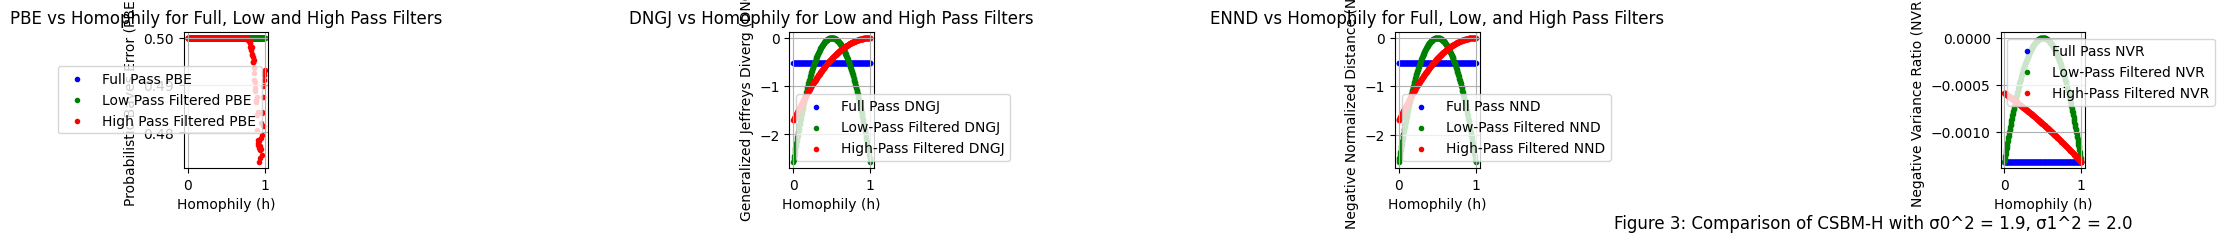

In [86]:
# sigma_0^2 changed to 1.9
'''
Plotting PBE, Dngj, NND and NVR
mu0 = [-1, 0]
mu1 = [0, 1]

sigma_0^2 = 1.9
sigma_1^2 = 2.0

d0 = 5
d1 = 5

fh = 2
'''
mu0 = np.array([-1, 0])
mu1 = np.array([0, 1])
sigma_square_0, sigma_square_1 = 1.9, 2.0  # Variances for each class
fh = 2
d0, d1 = 5, 5  # Degrees for each class

homophily_values = np.linspace(0,1, 250)

# Calculating PBE
pbe_fp_all = []
pbe_lp_all = []
pbe_hp_all = []

# Calculating Dngj
dngj_fp_all = []
dngj_lp_all = []
dngj_hp_all = []

# Calculating NND
nnd_fp_all = []
nnd_lp_all = []
nnd_hp_all = []

# Calculating NVR
nvr_fp_all = []
nvr_lp_all = []
nvr_hp_all = []


for h in homophily_values:
  pbe_fp, pbe_lp, pbe_hp = calculate_pbe_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  dngj_fp, dngj_lp, dngj_hp = calculate_dngj_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nnd_fp, nnd_lp, nnd_hp = calculate_nnd_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nvr_fp, nvr_lp, nvr_hp = calculate_nvr_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)

  pbe_fp_all.append(pbe_fp)
  pbe_lp_all.append(pbe_lp)
  pbe_hp_all.append(pbe_hp)

  dngj_fp_all.append(dngj_fp)
  dngj_lp_all.append(dngj_lp)
  dngj_hp_all.append(dngj_hp)

  nnd_fp_all.append(nnd_fp)
  nnd_lp_all.append(nnd_lp)
  nnd_hp_all.append(nnd_hp)

  nvr_fp_all.append(nvr_fp)
  nvr_lp_all.append(nvr_lp)
  nvr_hp_all.append(nvr_hp)


plt.figure(figsize=(20, 3))
# Plotting PBE
plt.subplot(1, 4, 1)
plt.scatter(homophily_values, pbe_fp_all, marker='.', c='b', label='Full Pass PBE')
plt.scatter(homophily_values, pbe_lp_all, marker='.', c='g', label='Low Pass Filtered PBE')
plt.scatter(homophily_values, pbe_hp_all, marker='.', c='r', label='High Pass Filtered PBE')
plt.grid(True)
plt.xlabel('Homophily (h)')
plt.ylabel('Probabilistic Bayes Error (PBE)')
plt.title('PBE vs Homophily for Full, Low and High Pass Filters')
plt.legend()

# Plotting Dngj
plt.subplot(1, 4, 2)
plt.scatter(homophily_values, dngj_fp_all, marker='.', c='b', label='Full Pass DNGJ')
plt.scatter(homophily_values, dngj_lp_all, marker='.', c='g', label='Low-Pass Filtered DNGJ')
plt.scatter(homophily_values, dngj_hp_all, marker='.', c='r', label='High-Pass Filtered DNGJ')
plt.xlabel('Homophily (h)')
plt.ylabel('Generalized Jeffreys Diverg (DNGJ)')
plt.title('DNGJ vs Homophily for Low and High Pass Filters')
plt.legend()
plt.grid(True)

# Plotting NND
plt.subplot(1, 4, 3)
plt.scatter(homophily_values, nnd_fp_all, marker='.', c='b', label='Full Pass NND')
plt.scatter(homophily_values, nnd_lp_all, marker='.', c='g', label='Low-Pass Filtered NND')
plt.scatter(homophily_values, nnd_hp_all, marker='.', c='r', label='High-Pass Filtered NND')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Normalized Distance (NND)')
plt.title('ENND vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

# Plotting NVR
plt.subplot(1, 4, 4)
plt.scatter(homophily_values, nvr_fp_all, marker='.', c='b', label='Full Pass NVR')
plt.scatter(homophily_values, nvr_lp_all, marker='.', c='g', label='Low-Pass Filtered NVR')
plt.scatter(homophily_values, nvr_hp_all, marker='.', c='r', label='High-Pass Filtered NVR')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Variance Ratio (NVR)')
plt.title('NVR vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

plt.title("Figure 3: Comparison of CSBM-H with σ0^2 = 1.9, σ1^2 = 2.0", y = -0.5, x = -1.5)
plt.tight_layout()
plt.show()

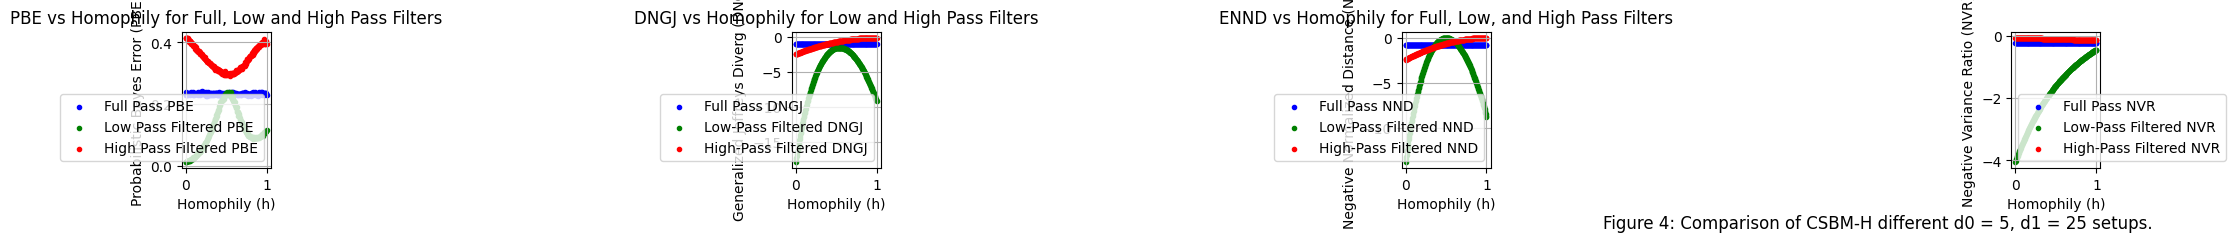

In [84]:
# d1 changed to 25
'''
Plotting PBE, Dngj, NND and NVR
mu0 = [-1, 0]
mu1 = [0, 1]

sigma_0^2 = 1.0
sigma_1^2 = 2.0

d0 = 5
d1 = 25

fh = 2
'''
mu0 = np.array([-1, 0])
mu1 = np.array([0, 1])
sigma_square_0, sigma_square_1 = 1.0, 2.0  # Variances for each class
fh = 2
d0, d1 = 5, 25  # Degrees for each class

homophily_values = np.linspace(0,1, 250)

# Calculating PBE
pbe_fp_all = []
pbe_lp_all = []
pbe_hp_all = []

# Calculating Dngj
dngj_fp_all = []
dngj_lp_all = []
dngj_hp_all = []

# Calculating NND
nnd_fp_all = []
nnd_lp_all = []
nnd_hp_all = []

# Calculating NVR
nvr_fp_all = []
nvr_lp_all = []
nvr_hp_all = []


for h in homophily_values:
  pbe_fp, pbe_lp, pbe_hp = calculate_pbe_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  dngj_fp, dngj_lp, dngj_hp = calculate_dngj_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nnd_fp, nnd_lp, nnd_hp = calculate_nnd_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nvr_fp, nvr_lp, nvr_hp = calculate_nvr_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)

  pbe_fp_all.append(pbe_fp)
  pbe_lp_all.append(pbe_lp)
  pbe_hp_all.append(pbe_hp)

  dngj_fp_all.append(dngj_fp)
  dngj_lp_all.append(dngj_lp)
  dngj_hp_all.append(dngj_hp)

  nnd_fp_all.append(nnd_fp)
  nnd_lp_all.append(nnd_lp)
  nnd_hp_all.append(nnd_hp)

  nvr_fp_all.append(nvr_fp)
  nvr_lp_all.append(nvr_lp)
  nvr_hp_all.append(nvr_hp)


plt.figure(figsize=(20, 3))
# Plotting PBE
plt.subplot(1, 4, 1)
plt.scatter(homophily_values, pbe_fp_all, marker='.', c='b', label='Full Pass PBE')
plt.scatter(homophily_values, pbe_lp_all, marker='.', c='g', label='Low Pass Filtered PBE')
plt.scatter(homophily_values, pbe_hp_all, marker='.', c='r', label='High Pass Filtered PBE')
plt.grid(True)
plt.xlabel('Homophily (h)')
plt.ylabel('Probabilistic Bayes Error (PBE)')
plt.title('PBE vs Homophily for Full, Low and High Pass Filters')
plt.legend()

# Plotting Dngj
plt.subplot(1, 4, 2)
plt.scatter(homophily_values, dngj_fp_all, marker='.', c='b', label='Full Pass DNGJ')
plt.scatter(homophily_values, dngj_lp_all, marker='.', c='g', label='Low-Pass Filtered DNGJ')
plt.scatter(homophily_values, dngj_hp_all, marker='.', c='r', label='High-Pass Filtered DNGJ')
plt.xlabel('Homophily (h)')
plt.ylabel('Generalized Jeffreys Diverg (DNGJ)')
plt.title('DNGJ vs Homophily for Low and High Pass Filters')
plt.legend()
plt.grid(True)

# Plotting NND
plt.subplot(1, 4, 3)
plt.scatter(homophily_values, nnd_fp_all, marker='.', c='b', label='Full Pass NND')
plt.scatter(homophily_values, nnd_lp_all, marker='.', c='g', label='Low-Pass Filtered NND')
plt.scatter(homophily_values, nnd_hp_all, marker='.', c='r', label='High-Pass Filtered NND')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Normalized Distance (NND)')
plt.title('ENND vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

# Plotting NVR
plt.subplot(1, 4, 4)
plt.scatter(homophily_values, nvr_fp_all, marker='.', c='b', label='Full Pass NVR')
plt.scatter(homophily_values, nvr_lp_all, marker='.', c='g', label='Low-Pass Filtered NVR')
plt.scatter(homophily_values, nvr_hp_all, marker='.', c='r', label='High-Pass Filtered NVR')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Variance Ratio (NVR)')
plt.title('NVR vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

plt.title("Figure 4: Comparison of CSBM-H different d0 = 5, d1 = 25 setups.", y = -0.5, x = -1.5)
plt.tight_layout()
plt.show()

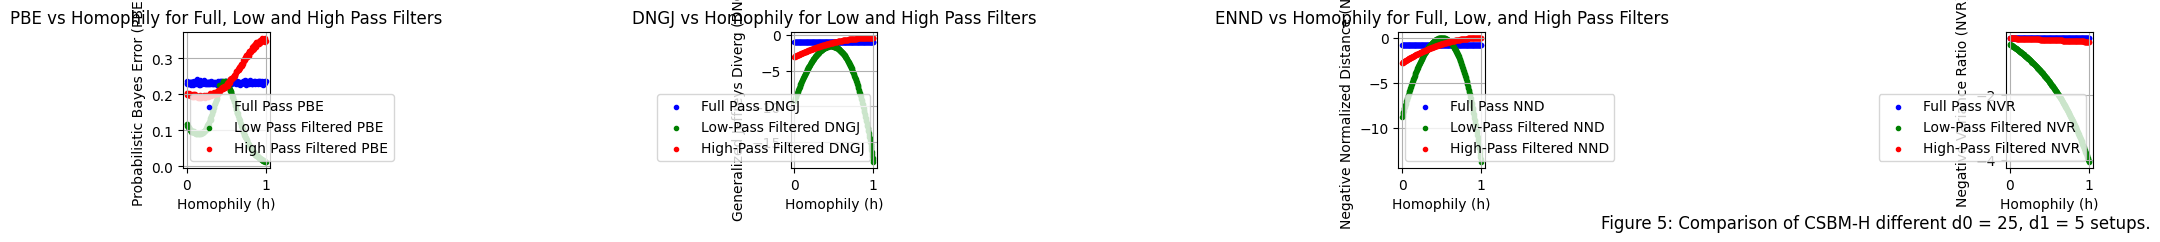

In [85]:
# d0 changed to 25
'''
Plotting PBE, Dngj, NND and NVR
mu0 = [-1, 0]
mu1 = [0, 1]

sigma_0^2 = 1.0
sigma_1^2 = 2.0

d0 = 25
d1 = 5

fh = 2
'''
mu0 = np.array([-1, 0])
mu1 = np.array([0, 1])
sigma_square_0, sigma_square_1 = 1.0, 2.0  # Variances for each class
fh = 2
d0, d1 = 25, 5  # Degrees for each class

homophily_values = np.linspace(0,1, 250)

# Calculating PBE
pbe_fp_all = []
pbe_lp_all = []
pbe_hp_all = []

# Calculating Dngj
dngj_fp_all = []
dngj_lp_all = []
dngj_hp_all = []

# Calculating NND
nnd_fp_all = []
nnd_lp_all = []
nnd_hp_all = []

# Calculating NVR
nvr_fp_all = []
nvr_lp_all = []
nvr_hp_all = []


for h in homophily_values:
  pbe_fp, pbe_lp, pbe_hp = calculate_pbe_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  dngj_fp, dngj_lp, dngj_hp = calculate_dngj_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nnd_fp, nnd_lp, nnd_hp = calculate_nnd_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)
  nvr_fp, nvr_lp, nvr_hp = calculate_nvr_all(mu0, mu1, sigma_square_0, sigma_square_1, d0, d1, h, fh)

  pbe_fp_all.append(pbe_fp)
  pbe_lp_all.append(pbe_lp)
  pbe_hp_all.append(pbe_hp)

  dngj_fp_all.append(dngj_fp)
  dngj_lp_all.append(dngj_lp)
  dngj_hp_all.append(dngj_hp)

  nnd_fp_all.append(nnd_fp)
  nnd_lp_all.append(nnd_lp)
  nnd_hp_all.append(nnd_hp)

  nvr_fp_all.append(nvr_fp)
  nvr_lp_all.append(nvr_lp)
  nvr_hp_all.append(nvr_hp)


plt.figure(figsize=(20, 3))
# Plotting PBE
plt.subplot(1, 4, 1)
plt.scatter(homophily_values, pbe_fp_all, marker='.', c='b', label='Full Pass PBE')
plt.scatter(homophily_values, pbe_lp_all, marker='.', c='g', label='Low Pass Filtered PBE')
plt.scatter(homophily_values, pbe_hp_all, marker='.', c='r', label='High Pass Filtered PBE')
plt.grid(True)
plt.xlabel('Homophily (h)')
plt.ylabel('Probabilistic Bayes Error (PBE)')
plt.title('PBE vs Homophily for Full, Low and High Pass Filters')
plt.legend()

# Plotting Dngj
plt.subplot(1, 4, 2)
plt.scatter(homophily_values, dngj_fp_all, marker='.', c='b', label='Full Pass DNGJ')
plt.scatter(homophily_values, dngj_lp_all, marker='.', c='g', label='Low-Pass Filtered DNGJ')
plt.scatter(homophily_values, dngj_hp_all, marker='.', c='r', label='High-Pass Filtered DNGJ')
plt.xlabel('Homophily (h)')
plt.ylabel('Generalized Jeffreys Diverg (DNGJ)')
plt.title('DNGJ vs Homophily for Low and High Pass Filters')
plt.legend()
plt.grid(True)

# Plotting NND
plt.subplot(1, 4, 3)
plt.scatter(homophily_values, nnd_fp_all, marker='.', c='b', label='Full Pass NND')
plt.scatter(homophily_values, nnd_lp_all, marker='.', c='g', label='Low-Pass Filtered NND')
plt.scatter(homophily_values, nnd_hp_all, marker='.', c='r', label='High-Pass Filtered NND')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Normalized Distance (NND)')
plt.title('ENND vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

# Plotting NVR
plt.subplot(1, 4, 4)
plt.scatter(homophily_values, nvr_fp_all, marker='.', c='b', label='Full Pass NVR')
plt.scatter(homophily_values, nvr_lp_all, marker='.', c='g', label='Low-Pass Filtered NVR')
plt.scatter(homophily_values, nvr_hp_all, marker='.', c='r', label='High-Pass Filtered NVR')
plt.xlabel('Homophily (h)')
plt.ylabel('Negative Variance Ratio (NVR)')
plt.title('NVR vs Homophily for Full, Low, and High Pass Filters')
plt.grid(True)
plt.legend()

plt.title("Figure 5: Comparison of CSBM-H different d0 = 25, d1 = 5 setups.", y = -0.5, x = -1.5)
plt.tight_layout()
plt.show()